<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/Users/days/w1d6/feature_vizu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will reproduce some results of https://distill.pub/2017/feature-visualization/

Answer the questions and complete the code.

In [ ]:
%pip install einops -q

In [ ]:
import torch
from torch import nn
import torchvision 
from torchvision import transforms

In [ ]:
model = torchvision.models.resnet34(pretrained=True)
model.eval();
# Why do we need to use model.eval()?

In [ ]:
import einops
import matplotlib.pyplot as plt


def imshow(img, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 4:
        img = img.squeeze(0)

    # Why do we need to rearange the dimensions?
    img_reshaped = einops.rearrange(img, 'c w h -> w h c')
    plt.imshow(img_reshaped.detach())
    plt.xticks([])
    plt.yticks([])


In [ ]:
# Why do we need TFORM?
# Why do you have the right to use TFORM?
TFORM = transforms.Compose([
    transforms.Pad(12),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomAffine(
        degrees=10, translate=(0.05, 0.05), scale=(1.2, 1.2), shear=10
    ),
])

In the same way as in the distill article, we will create several types of image parameterizations starting with the most naive parameterizations and going to the most efficient ones.
Images will be encoded as subclass of nn.Module, which will allow us to use pytorch abstractions to optimize images to maximize activation on a given class.

Please hide all forwards functions and try to write your own forwards functions.

### Naive parameterization

We can see the images simply as pixels independent of each other.

Note: By convention, in this TP, all images are in [0, 1]^3x224x224.

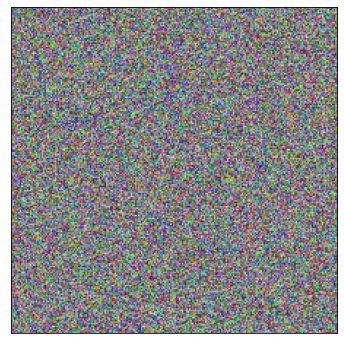

In [27]:
class pixelImage(nn.Module):
    def __init__(self):
        super().__init__()
        self.image = nn.Parameter(torch.rand(1, 3, 224, 224))
    
    def forward(self):
        return torch.clip(self.image, min=0.0, max=1.0)
    

class sigmoidImage(nn.Module):
    def __init__(self):
        super().__init__()
        self.image = nn.Parameter(torch.randn(1, 3, 224, 224))
    
    def forward(self):
        # Why sigmoid is better than clip?
        return self.image.sigmoid()

img = sigmoidImage()
imshow(img())

After writing the image as an nn.module network, we can optimize the img to :
- maximize the activation of the resnet model for a given output class
- So that it displays the optimized image at the end of the optimization.

Hide and rewrite the body of the optimize_img function.

In [ ]:
from tqdm.autonotebook import tqdm


def optimize_img(img, model, lr=0.05, n_epochs=200, class_id=50, apply_transforms: bool =False):
    """Maximize the output of the resnet for a given class.
    
    Use Adam to optimize the image.
    """
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = img.to(DEVICE)
    model = model.to(DEVICE)

    opt = torch.optim.Adam(img.parameters(), lr=lr)

    for _ in tqdm(range(n_epochs)):
        opt.zero_grad()
        image = img()
        if apply_transforms:
            image = TFORM(image)
        loss = -model(image)[0, class_id]
        loss.backward()
        opt.step()

    imshow(img().cpu())

    

100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


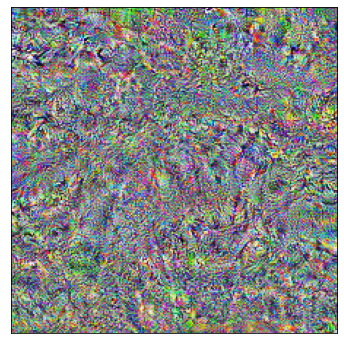

In [32]:
optimize_img(img, model)

The results are not good. We will apply a transformation to change the color space, as well as to change the spatial space in order to obtain a better parameterization.

### Whitening_transformation

In [ ]:
# Here, we decorate the colors of the image.

#Read about cholewsky decomposition
# https://en.wikipedia.org/wiki/Whitening_transformation
# Why is it better to decorelate the colors of the image? 


projection = torch.Tensor(
    [[0.26, 0.09, 0.02],
    [0.27, 0.00, -0.05],
    [0.27, -0.09, 0.03]]
)

# explain what is happenning in the torch.einsum?
# Can you spot some errors in the decorrImage code?

class decorrImage(nn.Module):

    def __init__(self, scale=1.0, sigmoid=False):
        super().__init__()
        self.image = nn.Parameter(torch.rand(1, 3, 224, 224))
        self.scale : float = scale
        self.use_sigmoid : bool = sigmoid
    
    def forward(self):
        image = torch.einsum('bchw, Cc -> bChw', self.image, projection)
        if self.use_sigmoid:
            return torch.sigmoid(image * self.scale + 0.5)
        else:
            return torch.clip(image * self.scale + 0.5, min=0.0, max=1.0)

# If you've spotted the errors, continue.

100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


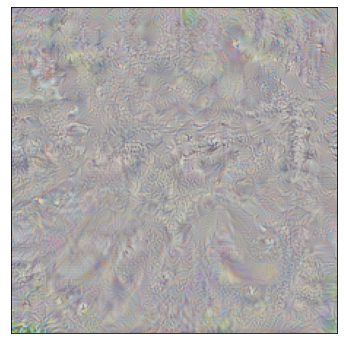

In [33]:
img = decorrImage(sigmoid=True)
optimize_img(img, model)

### Fourier

Skip this bonus part. First, go to the section inner seuron optimization.

In [5]:
    
class badFourierImage(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        self.scale = scale
        
    def forward(self):
        image = torch.fft.irfft2(torch.view_as_complex(self.freq))
        return torch.clip(image * self.scale + 0.5, min=0.0, max=1.0)
    
class fourierImage(nn.Module):
    def __init__(self, scale=1.0, sigmoid=False, learnable_scale=False):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        H, W = self.freq.shape[2:4]
        freq_magnitude = (torch.fft.fftfreq(H)[:,None]**2 + torch.fft.fftfreq(W)**2).sqrt()
        freq_magnitude[0, 0] = 1/H
        self.register_buffer('freq_magnitude', freq_magnitude)
        if learnable_scale:
            self.scale = nn.Parameter(torch.Tensor([scale]))
        else:
            self.scale = scale
        self.sigmoid = sigmoid
        
    def forward(self):        
        image = torch.fft.irfft2(torch.view_as_complex(self.freq) / self.freq_magnitude)
        image = image * self.scale + 0.5
        if self.sigmoid:
            return image.sigmoid()
        else:
            return torch.clip(image, min=0.0, max=1.0)
        
class decorrFourierImage(nn.Module):
    def __init__(self, scale=1.0, sigmoid=False):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        H, W = self.freq.shape[2:4]
        freq_magnitude = (torch.fft.fftfreq(H)[:,None]**2 + torch.fft.fftfreq(W)**2).sqrt()
        freq_magnitude[0, 0] = 1/H
        self.register_buffer('freq_magnitude', freq_magnitude)
        self.scale = scale
        self.sigmoid = sigmoid
        projection = torch.Tensor(
            [[0.26, 0.09, 0.02],
             [0.27, 0.00, -0.05],
             [0.27, -0.09, 0.03]])
        self.register_buffer('projection', projection)
        
    def forward(self):        
        image = torch.fft.irfft2(torch.view_as_complex(self.freq) / self.freq_magnitude)
        image = torch.einsum('bchw, Cc -> bChw', image, self.projection)
        image = image * self.scale + 0.5
        if self.sigmoid:
            return image.sigmoid()
        else:
            return torch.clip(image, min=0.0, max=1.0)        

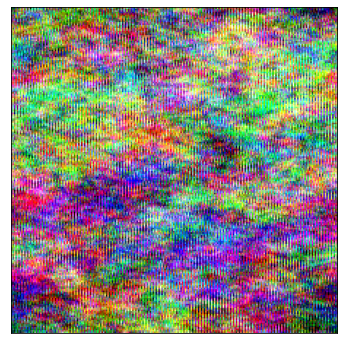

In [23]:
img = fourierImage(scale=10, sigmoid=False)
imshow(img())

100%|██████████| 200/200 [01:21<00:00,  2.44it/s]


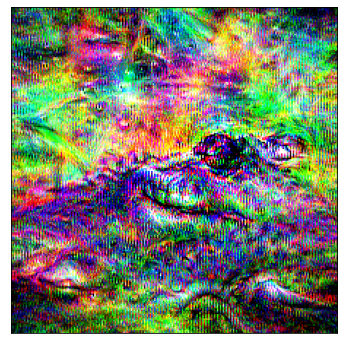

In [24]:
optimize_img(img, model, apply_transforms=True)

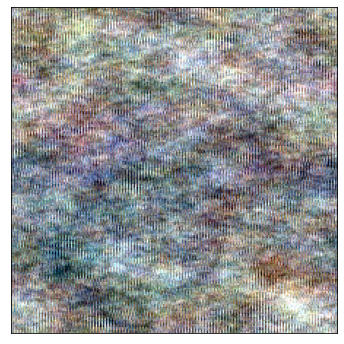

In [25]:
img = decorrFourierImage(scale=20)
imshow(img())

100%|██████████| 300/300 [02:03<00:00,  2.43it/s]


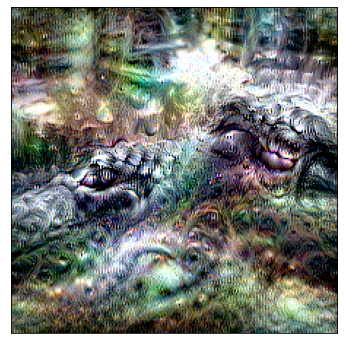

In [26]:
optimize_img(img, model, apply_transforms=True, n_epochs=300)

# Inner neuron optimization

Instead of maximizing the activation of one of the output classes of the neural network, we can maximize the output of an inner neuron.

Here, we will maximize the activation of a given class at the output of a ReLU layer.

Read the following code, understand, hide and rewrite.

You will need to understand the notion of hook: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks

To see some uses of hooks:
https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904#:~:text=PyTorch%20hooks%20are%20registered%20for,are%20used%20for%20debugging%20purposes.

In [37]:
"""
In the first part of this NB, we tried to maximize directly the output probability of the network.
Now we will try to activate only 


Strategy:
We have a resnet with N layers.
In each layer, after the convolution, there is a Relu.

Layer N-1   ->     Layer N    ->     Layer N+1
....        -> Conv ->  ReLU  -> 
           forward hook here⤴


After the N-th ReLU, we obtain C feature map (aka C channels/color/features)
We will register a forward hook to maximize the output of one of those channels.

This feature map looks like a very pixelated image. 
We will try to maximize the activation of each one of its pixels by maximizing the sum of the pixels.
"""

class SaveOutput:
    def __init__(self):
        self.output = None

    # what does the dunder __call__ in python?
    # What is the meaning of those 4 arguments :self, module, module_in, module_out?
    def __call__(self, module, module_in, module_out):
        """Forward pytorch hook"""
        self.output = module_out
        
    def clear(self):
        self.output = None



def optimize_img_inner(img, model, relu_id, channel_id, lr=0.05, n_epochs=200, apply_transforms=False):
    # optimizes an image to activate some intermediate-layer channel of post-ReLU activation
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = img.to(DEVICE)
    model = model.to(DEVICE)
    opt = torch.optim.Adam(img.parameters(), lr=lr)
    
    post_relu = []
    # What is the purpose of this for loop?
    for i, m in enumerate(model.modules()):
        if isinstance(m, nn.ReLU):
            hook = SaveOutput()
            post_relu.append(hook)
            m.register_forward_hook(hook)
    
    # What is the purpose of this for loop?
    for i in tqdm(range(n_epochs)):
        opt.zero_grad()
        image = img()
        if apply_transforms:
            image = TFORM(image)
            
        for hook in post_relu:
            hook.clear()
        model(image)
        
        loss = -(post_relu[relu_id].output[0, channel_id] **2).sum()
        # Why do we need the minus?
        # Do we really need the **2?
        loss.backward()
        opt.step()

    imshow(img().cpu())

"""
Answer the different questions.
Bonus: Delete SaveOutput and use a global variable and a function instead of a class.
You can draw inspiration from the gradCam exercice: https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/Grad_CAM.ipynb
"""

100%|██████████| 400/400 [01:14<00:00,  5.35it/s]


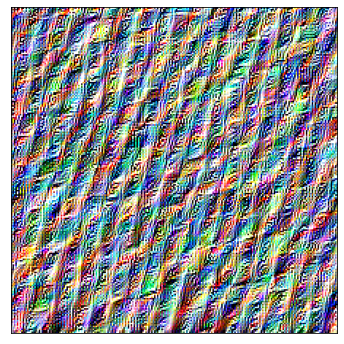

In [38]:
img = decorrFourierImage(scale=25.0)
optimize_img_inner(img, model, relu_id=4, channel_id=4, n_epochs=400)

"""
What happens when you change the relu_id? 
What happens when you change the channel_id?
take 5 minutes to browse openAi microscope: https://openai.com/blog/microscope/
"""